In [1]:
import json
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import torch.optim as optim


### Exploratory Data Analysis

Load TEST

In [3]:
df_test = pd.read_json('C:/Users/Aryaan Bazaz/OneDrive/Desktop/nlp_project/2020_acl_diplomacy-master/data/test.jsonl', lines=True)
df_test.head(5)


,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id
0,"[Hi Italy! Just opening up communication, and ...","[True, True, True, True, True]","[True, True, False, True, False]","[germany, italy, germany, germany, italy]","[italy, germany, italy, italy, germany]","[87, 132, 138, 207, 221]","[0, 1, 2, 3, 4]","[Spring, Spring, Spring, Winter, Winter]","[1901, 1901, 1901, 1901, 1901]","[3, 3, 3, 5, 4]","[0, 0, 0, 1, -1]","[italy, germany]",12
1,"[Hey Italy! What's your plan for the game?, Bo...","[True, True, False, True, True, True, True, Tr...","[True, True, True, True, True, NOANNOTATION, T...","[austria, italy, austria, italy, austria, ital...","[italy, austria, italy, austria, italy, austri...","[81, 128, 134, 135, 162, 222, 306, 308, 309, 527]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[Spring, Spring, Spring, Spring, Fall, Winter,...","[1901, 1901, 1901, 1901, 1901, 1901, 1902, 190...","[3, 3, 3, 3, 3, 4, 4, 5, 4, 4]","[0, 0, 0, 0, 0, -1, -1, 1, -1, -1]","[italy, austria]",12
2,"[Hey Italy! How’s it going?!, Hey hey, what ca...","[True, True, True, True, True, True]","[True, NOANNOTATION, True, NOANNOTATION, True,...","[russia, italy, russia, italy, russia, russia]","[italy, russia, italy, russia, italy, italy]","[35, 131, 254, 263, 313, 478]","[0, 1, 2, 3, 4, 5]","[Spring, Spring, Winter, Spring, Fall, Fall]","[1901, 1901, 1901, 1902, 1902, 1903]","[4, 3, 3, 4, 3, 5]","[1, -1, -1, 1, -1, 1]","[italy, russia]",12
3,"[Hello Italy, just wanted to thank you for you...","[True, True, True]","[True, True, True]","[england, italy, england]","[italy, england, italy]","[68, 127, 133]","[0, 1, 2]","[Spring, Spring, Spring]","[1901, 1901, 1901]","[3, 3, 3]","[0, 0, 0]","[italy, england]",12
4,[We both hate how I vs T just slows us both do...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[turkey, italy, italy, turkey, turkey, turkey,...","[italy, turkey, turkey, italy, italy, italy, t...","[31, 129, 412, 421, 434, 435, 486, 487, 488, 4...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1903, 1903, 1903, 1903, 1903, 190...","[3, 3, 4, 5, 5, 5, 4, 5, 4, 5, 4, 5, 5, 5, 4, ...","[0, 0, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1,...","[italy, turkey]",12


In [4]:
df_test.size

546

Load Train

In [5]:
df_train = pd.read_json('C:/Users/Aryaan Bazaz/OneDrive/Desktop/nlp_project/2020_acl_diplomacy-master/data/train.jsonl', lines=True)
df_train.head(5)

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id
0,[Germany!\n\nJust the person I want to speak w...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, NOANNOTATION, NOANNOT...","[italy, germany, italy, germany, italy, italy,...","[germany, italy, germany, italy, germany, germ...","[74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, germany]",1
1,[Hello there! What's your general plan for thi...,"[True, False, True, False, True, True, True, T...","[True, True, True, True, True, NOANNOTATION, T...","[austria, italy, austria, italy, italy, austri...","[italy, austria, italy, austria, austria, ital...","[1, 67, 71, 73, 98, 99, 101, 179, 181, 185, 18...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, -...","[italy, austria]",1
2,[Buongiorno! \nBe kinda nice to know if you're...,"[True, True, False, True, True, True, True, Tr...","[True, False, True, False, True, True, NOANNOT...","[russia, italy, russia, italy, russia, italy, ...","[italy, russia, italy, russia, italy, russia, ...","[11, 50, 52, 57, 61, 66, 77, 85, 96, 102, 116,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[4, 3, 4, 3, 4, 3, 4, 3, 3, 3, 4, 3, 3, 4, 4, ...","[1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1...","[italy, russia]",1
3,[Hey italy! good luck this game. I'm guessing ...,"[True, False, True, True, True, True, True, Tr...","[NOANNOTATION, True, True, False, True, True, ...","[england, italy, england, england, england, it...","[italy, england, italy, italy, italy, england,...","[32, 95, 106, 107, 108, 110, 113, 125, 126, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, england]",1
4,[Hello Italy what’s up what are your thoughts ...,"[True, False, False, True, True, True, True, T...","[NOANNOTATION, True, True, True, True, True, N...","[turkey, italy, italy, italy, turkey, italy, t...","[italy, turkey, turkey, turkey, italy, turkey,...","[45, 94, 103, 150, 154, 178, 192, 194, 195, 19...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Fall, Fall, F...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 1...","[italy, turkey]",1


In [12]:
df_train

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id
0,[Germany!\n\nJust the person I want to speak w...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, NOANNOTATION, NOANNOT...","[italy, germany, italy, germany, italy, italy,...","[germany, italy, germany, italy, germany, germ...","[74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, germany]",1
1,[Hello there! What's your general plan for thi...,"[True, False, True, False, True, True, True, T...","[True, True, True, True, True, NOANNOTATION, T...","[austria, italy, austria, italy, italy, austri...","[italy, austria, italy, austria, austria, ital...","[1, 67, 71, 73, 98, 99, 101, 179, 181, 185, 18...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, -...","[italy, austria]",1
2,[Buongiorno! \nBe kinda nice to know if you're...,"[True, True, False, True, True, True, True, Tr...","[True, False, True, False, True, True, NOANNOT...","[russia, italy, russia, italy, russia, italy, ...","[italy, russia, italy, russia, italy, russia, ...","[11, 50, 52, 57, 61, 66, 77, 85, 96, 102, 116,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[4, 3, 4, 3, 4, 3, 4, 3, 3, 3, 4, 3, 3, 4, 4, ...","[1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1...","[italy, russia]",1
3,[Hey italy! good luck this game. I'm guessing ...,"[True, False, True, True, True, True, True, Tr...","[NOANNOTATION, True, True, False, True, True, ...","[england, italy, england, england, england, it...","[italy, england, italy, italy, italy, england,...","[32, 95, 106, 107, 108, 110, 113, 125, 126, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, england]",1
4,[Hello Italy what’s up what are your thoughts ...,"[True, False, False, True, True, True, True, T...","[NOANNOTATION, True, True, True, True, True, N...","[turkey, italy, italy, italy, turkey, italy, t...","[italy, turkey, turkey, turkey, italy, turkey,...","[45, 94, 103, 150, 154, 178, 192, 194, 195, 19...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Fall, Fall, F...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 1...","[italy, turkey]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,[Greetings Sultan!\n\nAs your neighbor I would...,"[False, True, False, True, True, True, True, T...","[True, True, True, True, True, True, True, Tru...","[russia, turkey, russia, russia, russia, turke...","[turkey, russia, turkey, turkey, turkey, russi...","[78, 107, 145, 370, 371, 374, 415, 420, 495, 4...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1902, 1902, 1902, 1902, 190...","[4, 3, 4, 5, 5, 4, 5, 4, 5, 3, 7]","[1, -1, 1, 1, 1, -1, 1, -1, 2, -2, 7]","[russia, turkey]",10
185,[Greetings My Good Frenchman! \n\nHow are your...,"[True, True, True, True, True, True, True, Fal...","[True, True, False, True, True, True, True, Tr...","[russia, france, russia, russia, france, franc...","[france, russia, france, france, russia, russi...","[7

In [6]:
df_train.size

2457

Load VAL

In [13]:
df_val = pd.read_json('/content/validation.jsonl', lines=True)
df_val.head(5)

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id
0,"[Good afternoon to our friends in the south, j...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[germany, italy, germany, italy, italy, italy,...","[italy, germany, italy, germany, germany, germ...","[6, 11, 14, 96, 97, 98, 99, 106, 121, 133, 137...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, germany]",11
1,"[How’s it going Italy?, Relatively well. I'm d...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[austria, italy, italy, italy, italy, austria,...","[italy, austria, austria, austria, austria, it...","[1, 3, 32, 34, 38, 45, 78, 88, 89, 100, 101, 1...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, austria]",11
2,"[Hello :). How goes the mighty Tsar?, Hi Italy...","[True, True, True, True, True, True, True, Tru...","[NOANNOTATION, True, NOANNOTATION, NOANNOTATIO...","[italy, russia, italy, italy, italy, italy, ru...","[russia, italy, russia, russia, russia, russia...","[13, 64, 81, 82, 83, 84, 110, 112, 134, 135, 1...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 4, 3, 3, 3, 3, 4, 4, 3, 3, 3, 4, 4, 4, 4, ...","[-1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -...","[italy, russia]",11
3,[Hows everyones favorite Geopolitical Powerhou...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[italy, england, england, italy, italy, italy,...","[england, italy, italy, england, england, engl...","[33, 48, 49, 90, 91, 92, 93, 155, 193, 237, 31...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, england]",11
4,"[And how is the mighty Sultan today?, I’m doin...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[italy, turkey, italy, turkey, turkey, italy, ...","[turkey, italy, turkey, italy, italy, turkey, ...","[4, 16, 31, 36, 37, 39, 40, 94, 95, 104, 105, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, turkey]",11


In [14]:
df_val

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id
0,"[Good afternoon to our friends in the south, j...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[germany, italy, germany, italy, italy, italy,...","[italy, germany, italy, germany, germany, germ...","[6, 11, 14, 96, 97, 98, 99, 106, 121, 133, 137...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, germany]",11
1,"[How’s it going Italy?, Relatively well. I'm d...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[austria, italy, italy, italy, italy, austria,...","[italy, austria, austria, austria, austria, it...","[1, 3, 32, 34, 38, 45, 78, 88, 89, 100, 101, 1...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, austria]",11
2,"[Hello :). How goes the mighty Tsar?, Hi Italy...","[True, True, True, True, True, True, True, Tru...","[NOANNOTATION, True, NOANNOTATION, NOANNOTATIO...","[italy, russia, italy, italy, italy, italy, ru...","[russia, italy, russia, russia, russia, russia...","[13, 64, 81, 82, 83, 84, 110, 112, 134, 135, 1...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 4, 3, 3, 3, 3, 4, 4, 3, 3, 3, 4, 4, 4, 4, ...","[-1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -...","[italy, russia]",11
3,[Hows everyones favorite Geopolitical Powerhou...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[italy, england, england, italy, italy, italy,...","[england, italy, italy, england, england, engl...","[33, 48, 49, 90, 91, 92, 93, 155, 193, 237, 31...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, england]",11
4,"[And how is the mighty Sultan today?, I’m doin...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[italy, turkey, italy, turkey, turkey, italy, ...","[turkey, italy, turkey, italy, italy, turkey, ...","[4, 16, 31, 36, 37, 39, 40, 94, 95, 104, 105, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, turkey]",11
5,"[Hey Friend, how goes?, Hey Italy, everything ...","[True, True, False, False, True, True, True, T...","[True, False, True, True, True, True, True, Tr...","[italy, france, france, france, italy, italy, ...","[france, italy, italy, italy, france, france, ...","[12, 22, 23, 68, 85, 86, 87, 149, 186, 187, 18...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2,...","[italy, france]",11
6,[Seems the game has conspired to make us natur...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[germany, austria, germany, austria, austria, ...","[austria, germany, austria, germany, germany, ...","[5, 4

## Combining Traing and Validation
did not combine test data because the training and validation data together represent the whole dataset. the test dataset is just for performing the analysis

In [15]:
df_combined = pd.concat([df_train, df_val], ignore_index=True)


In [16]:
df_combined

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id
0,[Germany!\n\nJust the person I want to speak w...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, NOANNOTATION, NOANNOT...","[italy, germany, italy, germany, italy, italy,...","[germany, italy, germany, italy, germany, germ...","[74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, germany]",1
1,[Hello there! What's your general plan for thi...,"[True, False, True, False, True, True, True, T...","[True, True, True, True, True, NOANNOTATION, T...","[austria, italy, austria, italy, italy, austri...","[italy, austria, italy, austria, austria, ital...","[1, 67, 71, 73, 98, 99, 101, 179, 181, 185, 18...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, -...","[italy, austria]",1
2,[Buongiorno! \nBe kinda nice to know if you're...,"[True, True, False, True, True, True, True, Tr...","[True, False, True, False, True, True, NOANNOT...","[russia, italy, russia, italy, russia, italy, ...","[italy, russia, italy, russia, italy, russia, ...","[11, 50, 52, 57, 61, 66, 77, 85, 96, 102, 116,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[4, 3, 4, 3, 4, 3, 4, 3, 3, 3, 4, 3, 3, 4, 4, ...","[1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1...","[italy, russia]",1
3,[Hey italy! good luck this game. I'm guessing ...,"[True, False, True, True, True, True, True, Tr...","[NOANNOTATION, True, True, False, True, True, ...","[england, italy, england, england, england, it...","[italy, england, italy, italy, italy, england,...","[32, 95, 106, 107, 108, 110, 113, 125, 126, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, england]",1
4,[Hello Italy what’s up what are your thoughts ...,"[True, False, False, True, True, True, True, T...","[NOANNOTATION, True, True, True, True, True, N...","[turkey, italy, italy, italy, turkey, italy, t...","[italy, turkey, turkey, turkey, italy, turkey,...","[45, 94, 103, 150, 154, 178, 192, 194, 195, 19...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Fall, Fall, F...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 1...","[italy, turkey]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,[How’s it going? I usually bounce in the Black...,"[True, True, True, True, True, True, True, Tru...","[NOANNOTATION, NOANNOTATION, True, NOANNOTATIO...","[turkey, turkey, russia, turkey, turkey, russi...","[russia, russia, turkey, russia, russia, turke...","[18, 69, 70, 72, 73, 109, 111, 151, 223, 225, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 4, 3, 3, 4, 4, 3, 3, 3, 4, 4, 4, 3, 3, ...","[-1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1,...","[russia, turkey]",11
206,"[Hey Russia, how is it over there in the east?...","[True, True, False, True, True, True, True, Tr...","[NOANNOTATION, False, NOANNOTATION, True, NOAN...","[france, russia, france, russia, france, franc...","[russia, 

### Performing EDA on the Combined DataFrame.

describing the resultr of numeric feature i.e. game_id

In [17]:
df_combined.describe()

,game_id
count,210.00000
mean,6.20000
std,3.25738
min,1.00000
25%,3.00000
50%,6.50000
75%,9.00000
max,11.00000


Data types of each features - All are object type

In [18]:
df_combined.dtypes

,0
messages,object
sender_labels,object
receiver_labels,object
speakers,object
receivers,object
absolute_message_index,object
relative_message_index,object
seasons,object
years,object
game_score,object


In [ ]:
df_combined.isnull().any()

,0
messages,False
sender_labels,False
receiver_labels,False
speakers,False
receivers,False
absolute_message_index,False
relative_message_index,False
seasons,False
years,False
game_score,False


In [20]:
df_combined.isnull().sum()

,0
messages,0
sender_labels,0
receiver_labels,0
speakers,0
receivers,0
absolute_message_index,0
relative_message_index,0
seasons,0
years,0
game_score,0


No missing values...so no missing values to handle

In [21]:
df_combined

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id
0,[Germany!\n\nJust the person I want to speak w...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, NOANNOTATION, NOANNOT...","[italy, germany, italy, germany, italy, italy,...","[germany, italy, germany, italy, germany, germ...","[74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, germany]",1
1,[Hello there! What's your general plan for thi...,"[True, False, True, False, True, True, True, T...","[True, True, True, True, True, NOANNOTATION, T...","[austria, italy, austria, italy, italy, austri...","[italy, austria, italy, austria, austria, ital...","[1, 67, 71, 73, 98, 99, 101, 179, 181, 185, 18...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, -...","[italy, austria]",1
2,[Buongiorno! \nBe kinda nice to know if you're...,"[True, True, False, True, True, True, True, Tr...","[True, False, True, False, True, True, NOANNOT...","[russia, italy, russia, italy, russia, italy, ...","[italy, russia, italy, russia, italy, russia, ...","[11, 50, 52, 57, 61, 66, 77, 85, 96, 102, 116,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[4, 3, 4, 3, 4, 3, 4, 3, 3, 3, 4, 3, 3, 4, 4, ...","[1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1...","[italy, russia]",1
3,[Hey italy! good luck this game. I'm guessing ...,"[True, False, True, True, True, True, True, Tr...","[NOANNOTATION, True, True, False, True, True, ...","[england, italy, england, england, england, it...","[italy, england, italy, italy, italy, england,...","[32, 95, 106, 107, 108, 110, 113, 125, 126, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, england]",1
4,[Hello Italy what’s up what are your thoughts ...,"[True, False, False, True, True, True, True, T...","[NOANNOTATION, True, True, True, True, True, N...","[turkey, italy, italy, italy, turkey, italy, t...","[italy, turkey, turkey, turkey, italy, turkey,...","[45, 94, 103, 150, 154, 178, 192, 194, 195, 19...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Fall, Fall, F...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 1...","[italy, turkey]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,[How’s it going? I usually bounce in the Black...,"[True, True, True, True, True, True, True, Tru...","[NOANNOTATION, NOANNOTATION, True, NOANNOTATIO...","[turkey, turkey, russia, turkey, turkey, russi...","[russia, russia, turkey, russia, russia, turke...","[18, 69, 70, 72, 73, 109, 111, 151, 223, 225, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 4, 3, 3, 4, 4, 3, 3, 3, 4, 4, 4, 3, 3, ...","[-1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1,...","[russia, turkey]",11
206,"[Hey Russia, how is it over there in the east?...","[True, True, False, True, True, True, True, Tr...","[NOANNOTATION, False, NOANNOTATION, True, NOAN...","[france, russia, france, russia, france, franc...","[russia, 

Information of the dataset

In [22]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   messages                210 non-null    object
 1   sender_labels           210 non-null    object
 2   receiver_labels         210 non-null    object
 3   speakers                210 non-null    object
 4   receivers               210 non-null    object
 5   absolute_message_index  210 non-null    object
 6   relative_message_index  210 non-null    object
 7   seasons                 210 non-null    object
 8   years                   210 non-null    object
 9   game_score              210 non-null    object
 10  game_score_delta        210 non-null    object
 11  players                 210 non-null    object
 12  game_id                 210 non-null    int64 
dtypes: int64(1), object(12)
memory usage: 21.5+ KB


In [23]:
df_combined.describe()

,game_id
count,210.00000
mean,6.20000
std,3.25738
min,1.00000
25%,3.00000
50%,6.50000
75%,9.00000
max,11.00000


Columns/ features that are available

In [24]:
df_combined.columns


Index(['messages', 'sender_labels', 'receiver_labels', 'speakers', 'receivers',
       'absolute_message_index', 'relative_message_index', 'seasons', 'years',
       'game_score', 'game_score_delta', 'players', 'game_id'],
      dtype='object')

Histogram plot to show the frequency of word count per message

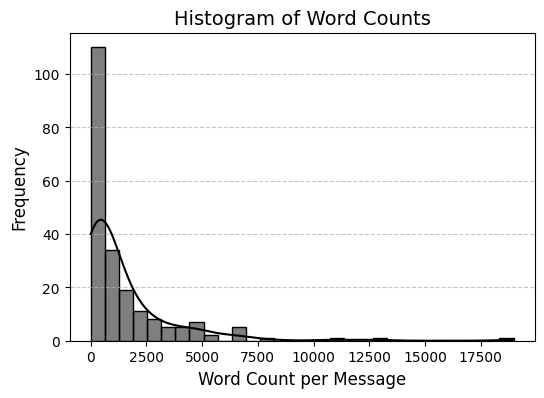

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_combined['word_count'] = df_combined['messages'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(6, 4))
sns.histplot(df_combined['word_count'], bins=30, kde=True, color='black')

plt.xlabel("Word Count per Message", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Histogram of Word Counts", fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [26]:
df_combined

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id,word_count
0,[Germany!\n\nJust the person I want to speak w...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, NOANNOTATION, NOANNOT...","[italy, germany, italy, germany, italy, italy,...","[germany, italy, germany, italy, germany, germ...","[74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, germany]",1,10830
1,[Hello there! What's your general plan for thi...,"[True, False, True, False, True, True, True, T...","[True, True, True, True, True, NOANNOTATION, T...","[austria, italy, austria, italy, italy, austri...","[italy, austria, italy, austria, austria, ital...","[1, 67, 71, 73, 98, 99, 101, 179, 181, 185, 18...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, -...","[italy, austria]",1,4124
2,[Buongiorno! \nBe kinda nice to know if you're...,"[True, True, False, True, True, True, True, Tr...","[True, False, True, False, True, True, NOANNOT...","[russia, italy, russia, italy, russia, italy, ...","[italy, russia, italy, russia, italy, russia, ...","[11, 50, 52, 57, 61, 66, 77, 85, 96, 102, 116,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[4, 3, 4, 3, 4, 3, 4, 3, 3, 3, 4, 3, 3, 4, 4, ...","[1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1...","[italy, russia]",1,2563
3,[Hey italy! good luck this game. I'm guessing ...,"[True, False, True, True, True, True, True, Tr...","[NOANNOTATION, True, True, False, True, True, ...","[england, italy, england, england, england, it...","[italy, england, italy, italy, italy, england,...","[32, 95, 106, 107, 108, 110, 113, 125, 126, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, england]",1,12689
4,[Hello Italy what’s up what are your thoughts ...,"[True, False, False, True, True, True, True, T...","[NOANNOTATION, True, True, True, True, True, N...","[turkey, italy, italy, italy, turkey, italy, t...","[italy, turkey, turkey, turkey, italy, turkey,...","[45, 94, 103, 150, 154, 178, 192, 194, 195, 19...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Fall, Fall, F...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 1...","[italy, turkey]",1,886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,[How’s it going? I usually bounce in the Black...,"[True, True, True, True, True, True, True, Tru...","[NOANNOTATION, NOANNOTATION, True, NOANNOTATIO...","[turkey, turkey, russia, turkey, turkey, russi...","[russia, russia, turkey, russia, russia, turke...","[18, 69, 70, 72, 73, 109, 111, 151, 223, 225, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 4, 3, 3, 4, 4, 3, 3, 3, 4, 4, 4, 3, 3, ...","[-1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1,...","[russia, turkey]",11,559
206,"[Hey Russia, how is it over there in the east?...","[True, True, False, True, True, True, True, Tr...","[NOANNOTATION, False, NOANNOTATION, True, NOAN...","[france, russia,

In [27]:
df_combined = pd.concat([df_train, df_val], ignore_index=True)

In [28]:
import pandas as pd
from collections import Counter

In [ ]:
import pandas as pd
import ast
from collections import Counter

df = pd.read_json("train.jsonl", lines=True)

false_position_counter = Counter({"start": 0, "mid": 0, "end": 0})

for i in range(10):
    sender_labels = ast.literal_eval(df.loc[i, "sender_labels"])
    n = len(sender_labels)
    
    start = sender_labels[:n//3]
    mid = sender_labels[n//3:2*n//3]
    end = sender_labels[2*n//3:]
    
    false_position_counter["start"] += start.count(False)
    false_position_counter["mid"] += mid.count(False)
    false_position_counter["end"] += end.count(False)

total_falses = sum(false_position_counter.values())
print("False label distribution across positions (in first 10 rows):")
for section, count in false_position_counter.items():
    percentage = (count / total_falses) * 100 if total_falses else 0
    print(f"{section.title()}: {count} ({percentage:.2f}%)")


### Keep in Mind
1. senders_label : Actual lie

   true means was Not lying
   false means lying

2. receivers_label : Suspected lie
   
   true means suspecting Not lie
   fasle means suspecting lie



Counting teh No. of Total messages

Managing the sender label count....how many true and false

Managing the receiver label count....how many true and false and not interpretable

In [ ]:
def eval(value):
    if isinstance(value, str):
        return eval(value) 
    return value 

df_combined['sender_labels'] = df_combined['sender_labels'].apply(eval)
df_combined['receiver_labels'] = df_combined['receiver_labels'].apply(eval)

sender_label_counts = Counter(label for sublist in df_combined['sender_labels'] for label in sublist)
receiver_label_counts = Counter(label for sublist in df_combined['receiver_labels'] for label in sublist)
total_messages = len(df_combined)

print("Total Messages:", total_messages)
print("Sender Label Counts:", sender_label_counts)
print("Receiver Label Counts:", receiver_label_counts)

Total Messages: 210
Sender Label Counts: Counter({True: 13901, False: 647})
Receiver Label Counts: Counter({True: 12695, 'NOANNOTATION': 1240, False: 613})


### comparative analysis

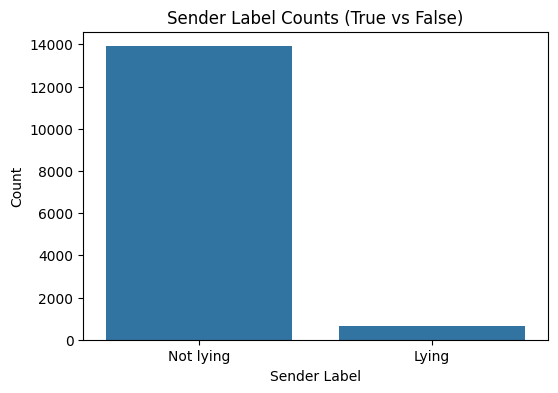

In [ ]:
labels = ["Not lying","Lying"]
values = list(sender_label_counts.values())
plt.figure(figsize=(6, 4))
sns.barplot(x=labels , y=values)

plt.xlabel("Sender Label")
plt.ylabel("Count")
plt.title("Sender Label Counts (True vs False)")

plt.show()

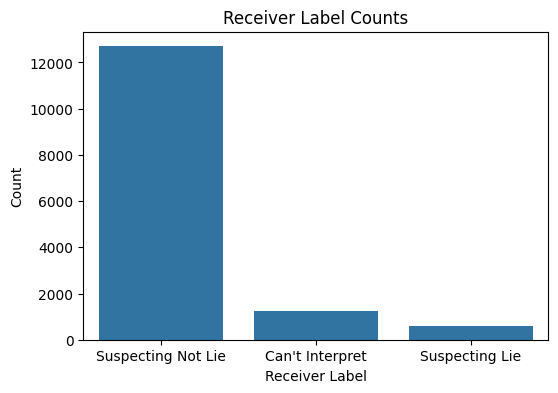

In [ ]:
labels = ["Suspecting Not Lie","Can't Interpret","Suspecting Lie"]
values = list(receiver_label_counts.values())
plt.figure(figsize=(6, 4))
sns.barplot(x=labels , y=values)

plt.xlabel("Receiver Label")
plt.ylabel("Count")
plt.title("Receiver Label Counts")
plt.show()

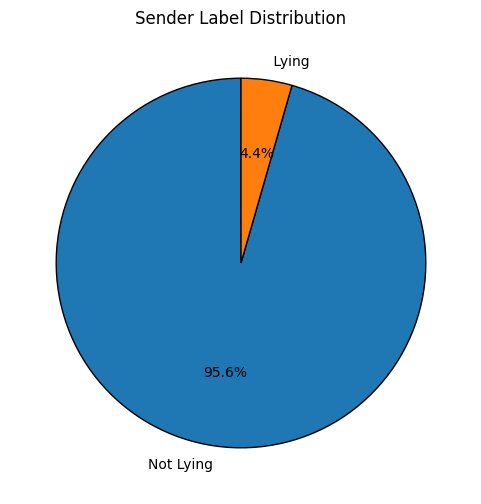

In [ ]:
import matplotlib.pyplot as plt

sender_label_counts = {"Not Lying": 13901, " Lying": 647}

labels = list(sender_label_counts.keys())
values = list(sender_label_counts.values())

plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title("Sender Label Distribution")
plt.show()


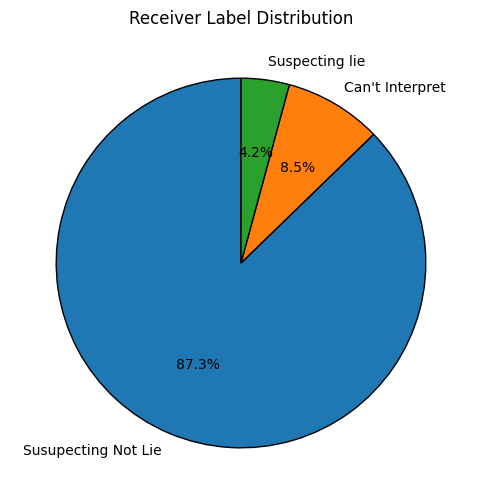

In [ ]:

import matplotlib.pyplot as plt
receiver_label_counts = {"Susupecting Not Lie": 12695, "Can't Interpret": 1240, "Suspecting lie": 613}

labels = list(receiver_label_counts.keys())
values = list(receiver_label_counts.values())

plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title("Receiver Label Distribution")
plt.show()


In [ ]:
import pandas as pd
straightforward = 0
cassandra = 0
deceived = 0
caught = 0

for index, row in df_combined.iterrows():
    sender_labels = row["sender_labels"]
    receiver_labels = row["receiver_labels"]

    if isinstance(sender_labels, list) and isinstance(receiver_labels, list):
        for sender, receiver in zip(sender_labels, receiver_labels):
            if sender == True and receiver == True:
                straightforward += 1
            elif sender == True and receiver == False:
                cassandra += 1
            elif sender == False and receiver == True:
                deceived += 1
            elif sender == False and receiver == False:
                caught += 1
print("Straightforward:", straightforward)
print("Cassandra:", cassandra)
print("Deceived:", deceived)
print("Caught:", caught)


Straightforward: 12169
Cassandra: 544
Deceived: 526
Caught: 69


<ipython-input-35-38f743774ac6>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=values, palette="viridis")


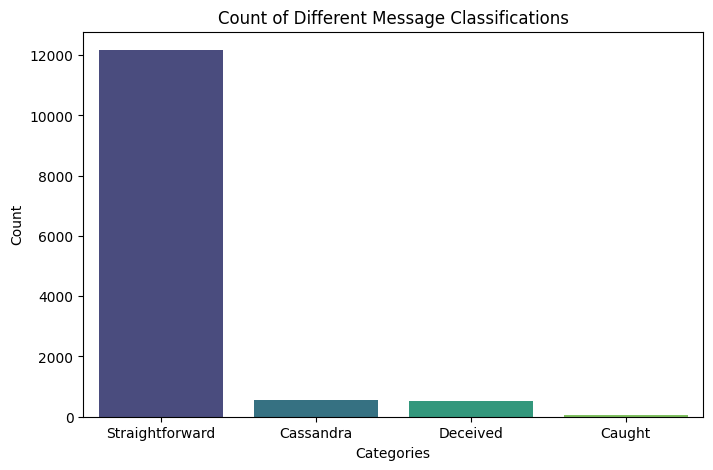

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
categories = ["Straightforward", "Cassandra", "Deceived", "Caught"]
values = [12169, 544, 526, 69]
plt.figure(figsize=(8, 5))
sns.barplot(x=categories, y=values, palette="viridis")
plt.xlabel("Categories")
plt.ylabel("Count")
plt.title("Count of Different Message Classifications")
plt.show()


In [ ]:
import pandas as pd
from collections import Counter

df = pd.read_json("C:/Users/Sneha/Downloads/nlp_project (1)/nlp_project/2020_acl_diplomacy-master/data/train.jsonl", lines=True)


false_position_counter = Counter({"start": 0, "mid": 0, "end": 0})

for i in range(len(df)):
    sender_labels = df.loc[i, "sender_labels"]

    if not isinstance(sender_labels, list):
        continue
    
    n = len(sender_labels)
    if n == 0:
        continue 

    start = sender_labels[:n//3]
    mid = sender_labels[n//3:2*n//3]
    end = sender_labels[2*n//3:]
    
    false_position_counter["start"] += start.count(False)
    false_position_counter["mid"] += mid.count(False)
    false_position_counter["end"] += end.count(False)

total_falses = sum(false_position_counter.values())
print("False label distribution across positions:")
for section, count in false_position_counter.items():
    percentage = (count / total_falses) * 100 if total_falses else 0
    print(f"{section.title()}: {count} ({percentage:.2f}%)")


False label distribution across positions:
Start: 189 (31.98%)
Mid: 177 (29.95%)
End: 225 (38.07%)


In [ ]:
import pandas as pd
import re
from collections import Counter

hedging_words = ["maybe", "possibly", "don’t worry", "not sure", "hopefully", "might", "could", "guess"]

strategic_words = ["support", "move", "army", "attack", "defend", "hold", "build", "fleet", "unit"]


df = pd.read_json("C:/Users/Sneha/Downloads/nlp_project (1)/nlp_project/2020_acl_diplomacy-master/data/train.jsonl", lines=True)


word_use_stats = {
    "deceptive_hedge": 0,
    "truthful_hedge": 0,
    "deceptive_strategic": 0,
    "truthful_strategic": 0
}


for i in range(len(df)):
    messages = df.loc[i, "messages"]
    sender_labels = df.loc[i, "sender_labels"]
    
    if not isinstance(messages, list) or not isinstance(sender_labels, list):
        continue
    
    for msg, label in zip(messages, sender_labels):
        if not isinstance(msg, str):
            continue
        msg_lower = msg.lower()
        
        hedge_found = any(re.search(rf"\b{re.escape(word)}\b", msg_lower) for word in hedging_words)
        strategic_found = any(re.search(rf"\b{re.escape(word)}\b", msg_lower) for word in strategic_words)
        
        if label is False:
            word_use_stats["deceptive_hedge"] += hedge_found
            word_use_stats["deceptive_strategic"] += strategic_found
        elif label is True:
            word_use_stats["truthful_hedge"] += hedge_found
            word_use_stats["truthful_strategic"] += strategic_found

print("\nKeyword Usage in Deceptive vs Truthful Messages:\n")
for key, count in word_use_stats.items():
    print(f"{key.replace('_', ' ').title()}: {count}")



Keyword Usage in Deceptive vs Truthful Messages:

Deceptive Hedge: 112
Truthful Hedge: 1453
Deceptive Strategic: 196
Truthful Strategic: 2832


In [16]:
print(f"Deceptive Hedge Percentage: {(112 / 647) * 100:.2f}%")
print(f"Truthful Hedge Percentage: {(1453 / 13901) * 100:.2f}%")
print(f"Deceptive Strategic Percentage: {(196 / 647) * 100:.2f}%")
print(f"Truthful Strategic Percentage: {(2832 / 13901) * 100:.2f}%")


Deceptive Hedge Percentage: 17.31%
Truthful Hedge Percentage: 10.45%
Deceptive Strategic Percentage: 30.29%
Truthful Strategic Percentage: 20.37%


In [ ]:
import pandas as pd
from collections import Counter

df = pd.read_json("C:/Users/Sneha/Downloads/nlp_project (1)/nlp_project/2020_acl_diplomacy-master/data/train.jsonl", lines=True)

length_deception = []

for _, row in df.iterrows():
    messages = row["messages"]
    sender_labels = row["sender_labels"]

    for msg, label in zip(messages, sender_labels):
        msg_len = len(msg.split())  
        length_deception.append((msg_len, label))

short_threshold = 5
long_threshold = 30

category_counts = Counter({"short": 0, "normal": 0, "long": 0})
deceptive_counts = Counter({"short": 0, "normal": 0, "long": 0})

for length, label in length_deception:
    if length <= short_threshold:
        category = "short"
    elif length >= long_threshold:
        category = "long"
    else:
        category = "normal"

    category_counts[category] += 1
    if label is False:
        deceptive_counts[category] += 1

print("Message Deception by Length Category:\n")
for category in ["short", "normal", "long"]:
    total = category_counts[category]
    deceptive = deceptive_counts[category]
    percent = (deceptive / total * 100) if total else 0
    print(f"{category.title()} Messages - Total: {total}, Deceptive: {deceptive} ({percent:.2f}%)")


Message Deception by Length Category:

Short Messages - Total: 2377, Deceptive: 61 (2.57%)
Normal Messages - Total: 7905, Deceptive: 314 (3.97%)
Long Messages - Total: 2850, Deceptive: 216 (7.58%)
